# Configuracion

In [2]:
#Pueden utiilizar la funcion convolve de scipy para realizar las convoluciones necesarias
from scipy import ndimage
from skimage import filters
from skimage import util
import skimage.io as io
from skimage import exposure
from skimage import img_as_ubyte
from skimage import img_as_float

import matplotlib.pyplot as plt
import numpy as np

import os

#Imagenes de color RGB
Las imagenes digitales a color estaran compuestas por 3 dimensiones, cada una representando un canal diferente de color.

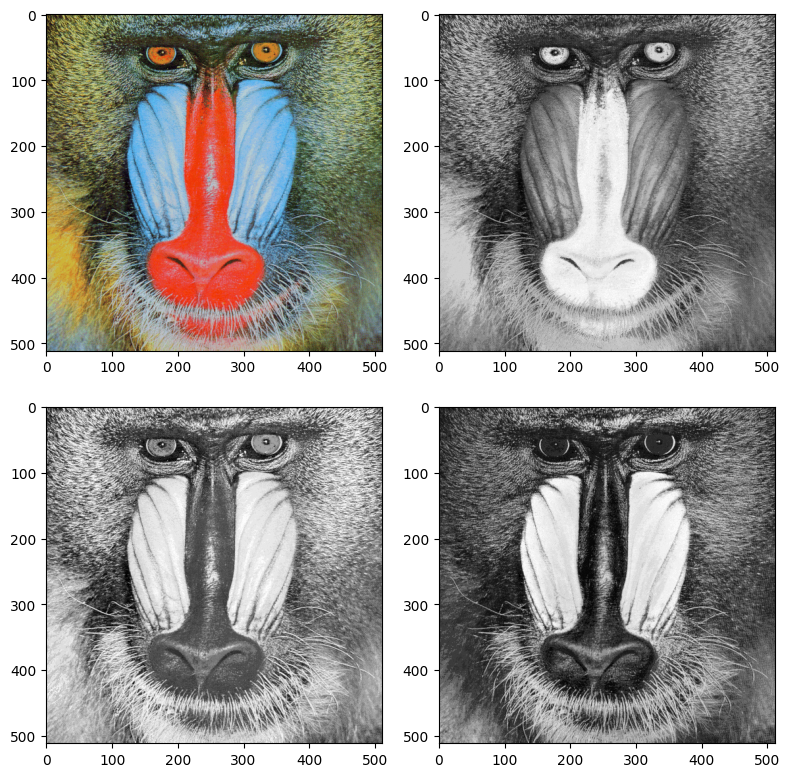

In [3]:
# Indicamos el camino a la imagen
dir_actual = os.getcwd()
imagenFilename = os.path.join(dir_actual,'Imagenes de pruebas','mandril_color.tif')

# Abrimos la imagen sin pasarla a escala de gris.
imagenPrueba = io.imread(imagenFilename)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(imagenPrueba) # Imagen Compuesta
ax[1].imshow(imagenPrueba[:,:,0], cmap=plt.cm.gray) # Canal Rojo
ax[2].imshow(imagenPrueba[:,:,1], cmap=plt.cm.gray) # Canal Verde
ax[3].imshow(imagenPrueba[:,:,2], cmap=plt.cm.gray) # Canal Azul

fig.tight_layout()
plt.show()

# Histograma Por Canal



In [4]:
def histogramasPorCanalRGB(image):
    histogramaR, _ = np.histogram(image[:,:,0], bins=256, range=(0, 256))
    histogramaG, _ = np.histogram(image[:,:,1], bins=256, range=(0, 256))
    histogramaB, _ = np.histogram(image[:,:,2], bins=256, range=(0, 256))
    
    return histogramaR,histogramaG,histogramaB

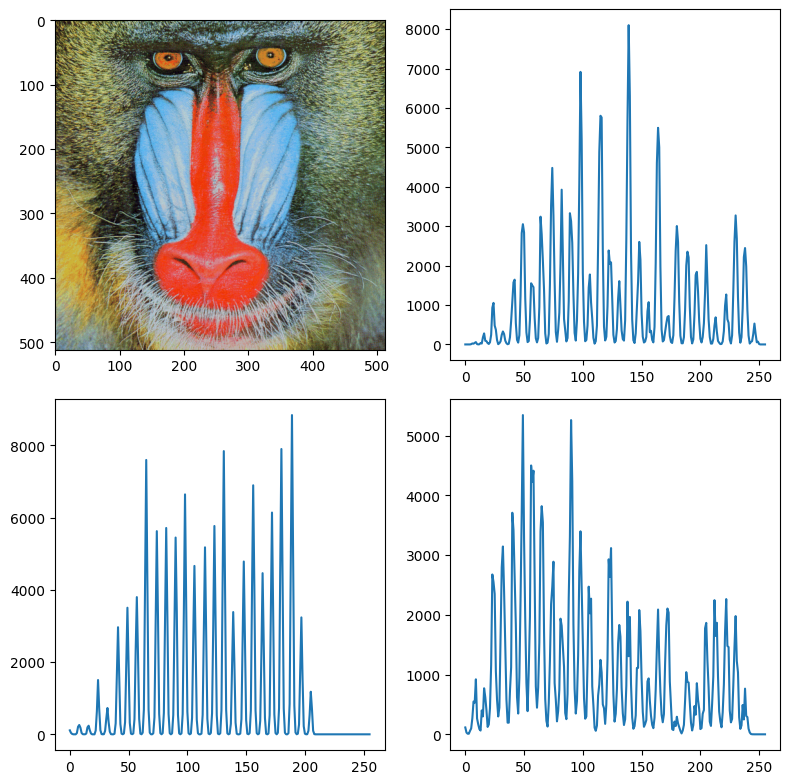

In [5]:
histR, histG, histB = histogramasPorCanalRGB(imagenPrueba)

# Mostramos el resultado final
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

# Usamos imshow para graficar imagenes, utilizando el cmap plt.cm.gray para especificar que esta en escala de grises
ax[0].imshow(imagenPrueba)
ax[1].plot(range(256), histR)
ax[2].plot(range(256), histG)
ax[3].plot(range(256), histB)

fig.tight_layout()
plt.show()


# Ecualizacion de Histograma por Canal
Realizar la ecualizacion por cada uno de los canales y mostrar las imagenes resultantes de modificar un histograma y mantener los otros 2. Por ultimo, imprimir la imagen con sus 3 canales ecualizados.

*(ayuda: pueden utilizar exposure.equalize_hist(img))*

In [17]:
def equalizar(img): 
    for i in range(3): img[:,:,i] = exposure.equalize_hist(img[:,:,i])

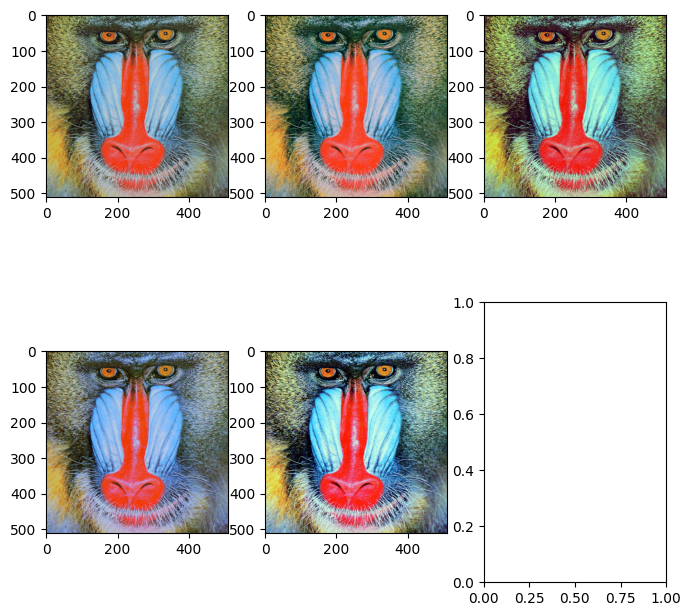

In [14]:
#Creamos los vectores donde guardar las imagenes ecualizadas
imgEcualizadaRojo = imagenPrueba.copy()
imgEcualizadaVerde = imagenPrueba.copy()
imgEcualizadaAzul = imagenPrueba.copy()
imgEcualizada = imagenPrueba.copy()
# Ecualizamos el canal azul de la imagen utilizando exposure.equalize_hist, nos devuelve una imagen 
# en formato float64 (0,1)
# Convertimos la imagen de float a uint8 utilizando img_as_ubyte

equa = [img_as_ubyte(exposure.equalize_hist(imgEcualizadaRojo[:,:,i])) for i in range(3)]

imgEcualizadaRojo[:,:,0] = equa[0]
imgEcualizadaVerde[:,:,1] = equa[1]
imgEcualizadaAzul[:,:,2] = equa[2]

for i in range(3): imgEcualizada[:,:,i] = equa[i]

fig, axes = plt.subplots(2, 3, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(imagenPrueba)
ax[1].imshow(imgEcualizadaRojo)
ax[2].imshow(imgEcualizadaVerde)
ax[3].imshow(imgEcualizadaAzul)
ax[4].imshow(imgEcualizada)

# Conversion HSI a RGB y viceversa

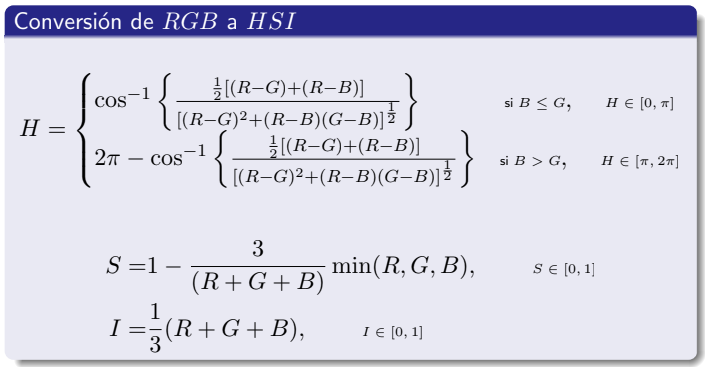


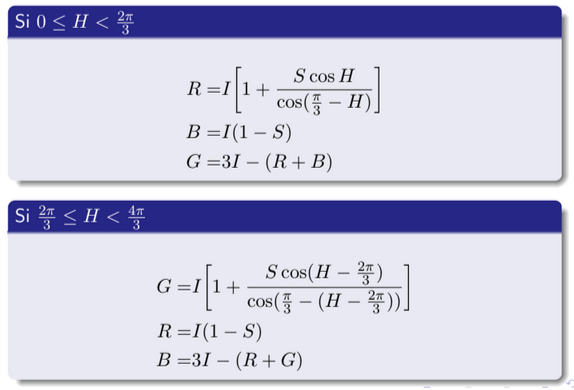

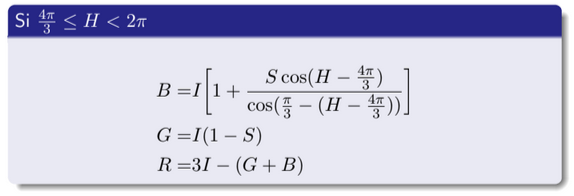



In [7]:
def RGBaHSI(image):
    rgbNormalizado = img_as_float(image)
    
    R = rgbNormalizado[:, :, 0]
    G = rgbNormalizado[:, :, 1]
    B = rgbNormalizado[:, :, 2]

    # Calcular la intensidad
    I = (R + G + B) / 3.0

    # Calcular Saturación
    min_rgb = np.minimum(np.minimum(R, G), B)
    S = 1 - (3 / (R + G + B + 1e-6)) * min_rgb
    S[R + G + B == 0] = 0  # Evita la división por cero

    # Calcular Hue-Tono 
    numerator = 0.5 * ((R - G) + (R - B)) 
    denominator = np.sqrt((R - G) ** 2 + (R - B) * (G - B)) + 1e-6  # Para evitar división por cero
    theta = np.arccos(numerator / denominator)

    # Asignar Hue según la posición de B
    H = np.zeros_like(R)
    H[B <= G] = theta[B <= G]
    H[B > G] = 2 * np.pi - theta[B > G]
    # H = H / (2 * np.pi)  # Normalizar a [0, 1]

    # Concatenar los canales H, S e I para formar la imagen HSI
    hsi_image = np.stack((H, S, I), axis=2)

    return hsi_image

In [8]:
def HSIaRGB(image):
    H = image[:, :, 0]
    S = image[:, :, 1]
    I = image[:, :, 2]
    
    R = np.zeros_like(H)
    G = np.zeros_like(H)
    B = np.zeros_like(H)

    # Caso 1: 0 <= H < 2π/3
    mask = (0 <= H) & (H < 2 * np.pi / 3)
    B[mask] = I[mask] * (1 - S[mask])
    R[mask] = I[mask] * (1 + S[mask] * np.cos(H[mask]) / np.cos(np.pi / 3 - H[mask]))
    G[mask] = 3 * I[mask] - (R[mask] + B[mask])

    # Caso 2: 2π/3 <= H < 4π/3
    mask = (2 * np.pi / 3 <= H) & (H < 4 * np.pi / 3)
    H_shifted = H[mask] - 2 * np.pi / 3
    R[mask] = I[mask] * (1 - S[mask])
    G[mask] = I[mask] * (1 + S[mask] * np.cos(H_shifted) / np.cos(np.pi / 3 - H_shifted))
    B[mask] = 3 * I[mask] - (R[mask] + G[mask])

    # Caso 3: 4π/3 <= H < 2π
    mask = (4 * np.pi / 3 <= H) & (H < 2 * np.pi)
    H_shifted = H[mask] - 4 * np.pi / 3
    B[mask] = I[mask] * (1 + S[mask] * np.cos(H_shifted) / np.cos(np.pi / 3 - H[mask]))
    G[mask] = I[mask] * (1 - S[mask])
    R[mask] = 3 * I[mask] - (G[mask] + B[mask])

    # Combinar los canales en una sola imagen RGB y escalar al rango [0, 255]
    rgb_image = np.clip(np.stack((R, G, B), axis=2), 0, 1) * 255
    
    return rgb_image.astype(np.uint8)

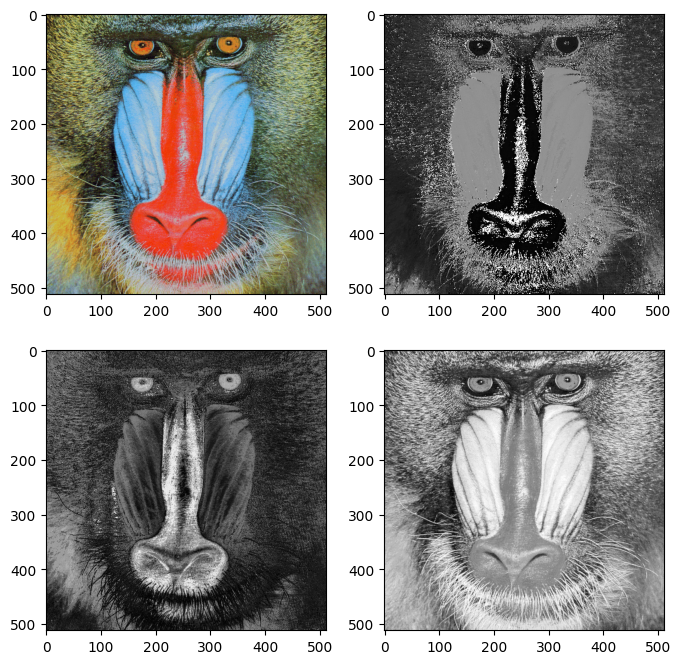

In [9]:
imageHSI = RGBaHSI(imagenPrueba)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(imagenPrueba)
ax[1].imshow(imageHSI[:,:,0], cmap=plt.cm.gray)
ax[2].imshow(imageHSI[:,:,1], cmap=plt.cm.gray)
ax[3].imshow(imageHSI[:,:,2], cmap=plt.cm.gray)

# Ecualizacion de Intensidad

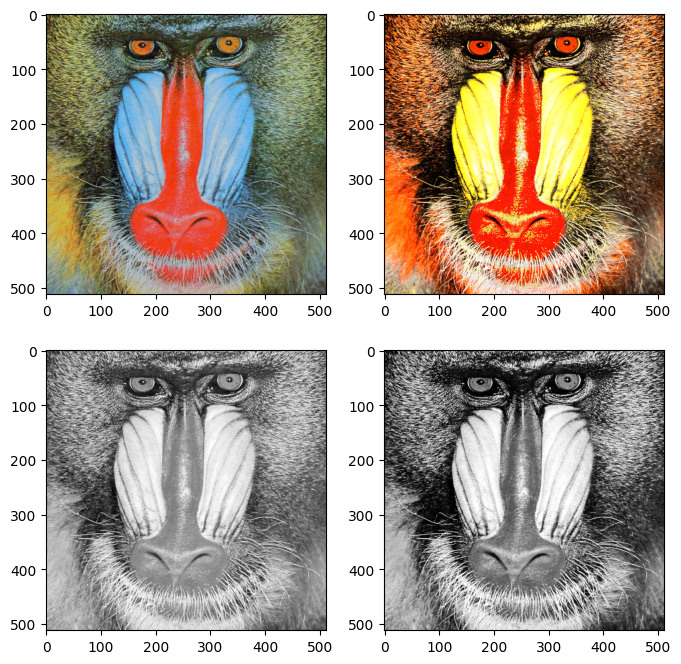

In [18]:
imageHSI = RGBaHSI(imagenPrueba)
imageHSIEcualizada = imageHSI.copy() #ECUALIZAR

equalizar(imageHSIEcualizada)

imageRGBEcualizada = HSIaRGB(imageHSIEcualizada)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(imagenPrueba)
ax[1].imshow(imageRGBEcualizada)
ax[2].imshow(imageHSI[:,:,2], cmap=plt.cm.gray)
ax[3].imshow(imageHSIEcualizada[:,:,2], cmap=plt.cm.gray)

# Operadores Puntales en HSI
Escriban sus propios operadores puntuales y apliquen diferentes operaciones a cada canal por separado, estudiando como resulta la imagen al volver a RGB.

*(ayuda: utilizar la funcion np.vectorize para convertir una funcion puntual en un operador para toda la matriz. El resultado de la funcion siempre debe estar entre 0 y 1)*

In [41]:
#Funcion de ejemplo que invierte el valor, suponiendo que esta en escala (0,1)
def operadorEjemplo1(pixel):
    return 1-pixel

#factor > 1 aumenta la intensidad, 0 < factor < 1 la reduce
def operadorEjemplo2(pixel,factor:float=2):
    return max(min(factor*pixel,1.0),0.0)

def umbralizacion(pixel,umbral:float): 
    return 1.0 if pixel > umbral else 0.0 

def ajustar_contraste(pixel,ref:float=0.5,factor:float=1.5): 
    return max(min(ref + factor * (pixel - ref), 1.0), 0.0)
    
def mostrarCambio(imgs): 
    imagenPrueba,imagenRGBModificada,imageHSI,imageHSIModificada = imgs 
    
    fig, axes = plt.subplots(4, 2, figsize=(8, 8))
    ax = axes.ravel()
    
    ax[0].imshow(imagenPrueba)
    ax[0].set_title("RGB-Original")
    ax[1].imshow(imageRGBModificada)
    ax[1].set_title("RGB-mod")
    ax[2].imshow(imageHSI[:,:,0], cmap=plt.cm.gray)
    ax[3].imshow(imageHSIModificada[:,:,0], cmap=plt.cm.gray)
    ax[4].imshow(imageHSI[:,:,1], cmap=plt.cm.gray)
    ax[5].imshow(imageHSIModificada[:,:,1], cmap=plt.cm.gray)
    ax[6].imshow(imageHSI[:,:,2], cmap=plt.cm.gray)
    ax[7].imshow(imageHSIModificada[:,:,2], cmap=plt.cm.gray)
    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()

In [42]:
op_punt_ej1 = np.vectorize(operadorEjemplo1)
op_punt_ej2 = np.vectorize(operadorEjemplo2)
op_punt_umbra = np.vectorize(umbralizacion)
op_punt_ajust = np.vectorize(ajustar_contraste)

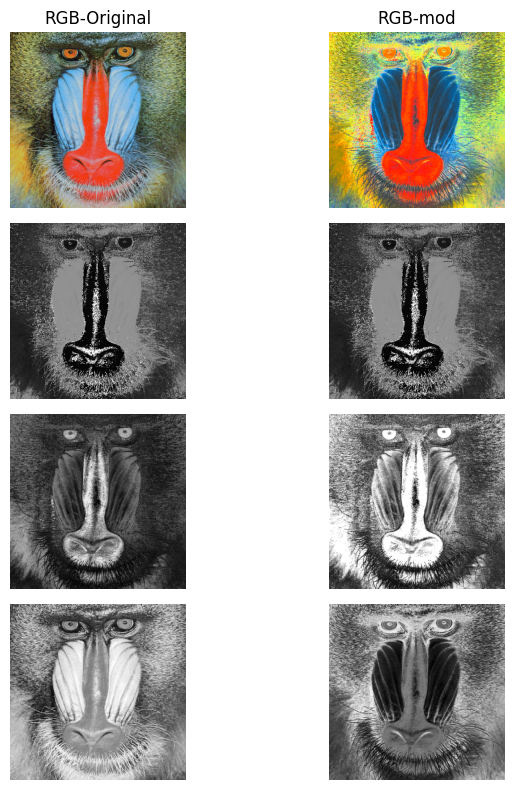

In [39]:
imageHSI = RGBaHSI(imagenPrueba)
imageHSIModificada = imageHSI.copy()
imageHSIModificada[:,:,1] = op_punt_ej2(imageHSIModificada[:,:,1])
imageHSIModificada[:,:,2] = op_punt_ej1(imageHSIModificada[:,:,2])

imageRGBModificada = HSIaRGB(imageHSIModificada)

mostrarCambio([imagenPrueba,imageRGBModificada,imageHSIModificada])

* No toca el **Tono**
* **Satura** el doble     (0 negro 1 blanco)
* Inverte la **Intensidad**

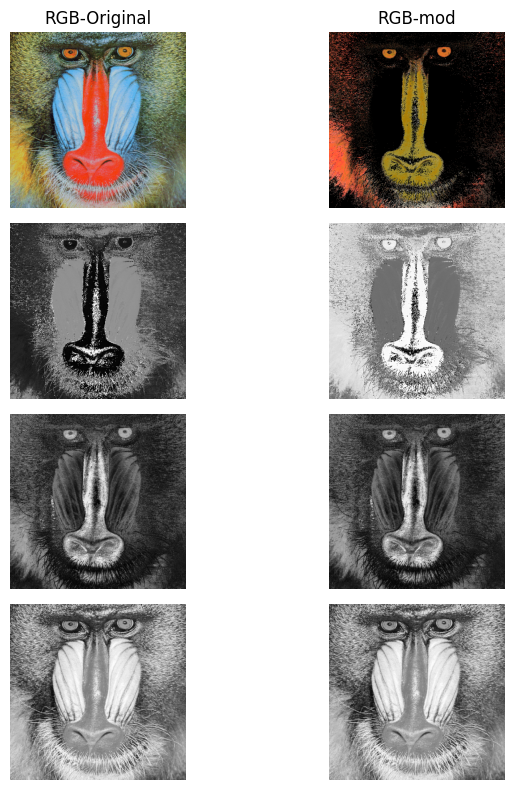

In [44]:
imageHSI = RGBaHSI(imagenPrueba)
imageHSIModificada = imageHSI.copy()
imageHSIModificada[:,:,0] = op_punt_ej1(imageHSIModificada[:,:,0])

imageRGBModificada = HSIaRGB(imageHSIModificada)

mostrarCambio([imagenPrueba,imageRGBModificada,imageHSI,imageHSIModificada])

# Realce de Saturacion
Multiplicar por una constante c > 1 cada pixel en el plano de la saturacion. Ver que esto aumenta la intensidad aparente.

Si c < 1 ver que reduce la intensidad del color.

In [47]:
def realce_sat(imgs): 
    imagenPrueba,imagenRGBModificada,imageHSI,imageHSIModificada = imgs
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    ax = axes.ravel()
    
    ax[0].imshow(imagenPrueba)
    ax[1].imshow(imageRGBModificada)
    
    ax[2].imshow(imageHSI[:,:,1], cmap=plt.cm.gray)
    ax[3].imshow(imageHSIModificada[:,:,1], cmap=plt.cm.gray)
    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()

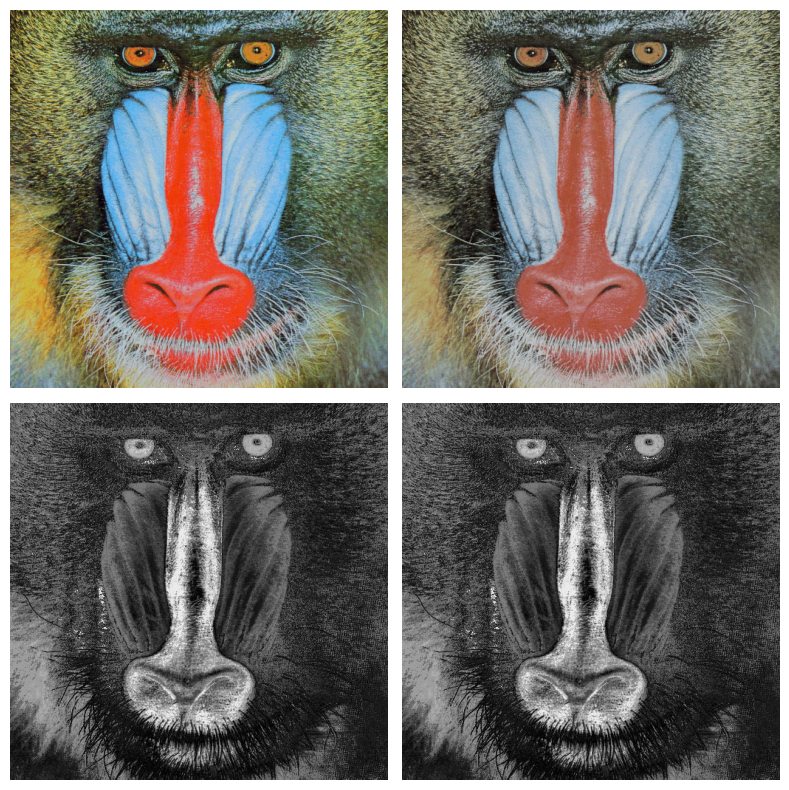

In [51]:
imageHSI = RGBaHSI(imagenPrueba)
imageHSIModificada = imageHSI.copy()
imageHSIModificada[:,:,1] = op_punt_ej2(imageHSIModificada[:,:,1],0.5)
# Asegurense que la Saturacion se encuentra en el rango (0,1) luego de aplicar la transformacion
imageRGBModificada = HSIaRGB(imageHSIModificada)
realce_sat([imagenPrueba,imageRGBModificada,imageHSI,imageHSIModificada])

# Alteracion de Hue (cambio de tono)
Sumar la constante c a los valores del canal H y ver el efecto en los colores cuando c es muy chico y que sucede cuando c es muy grande.

(ayuda: Recordar que el tono representa un angulo en la *rueda de color*, donde 0 = 0 y 1 = 2π. Si al sumar una constante el valor es mayor a 1, el angulo deberia *dar la vuelta* como las manijas de un reloj. Lo mismo si c es negativo)

Por ejemplo, si c fuera 0.5, es decir sumar el angulo π, la transformacion tendria la forma:

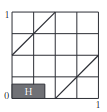

In [ ]:
def cambioDeTono(tonoPixel, c):
  return tonoPixel

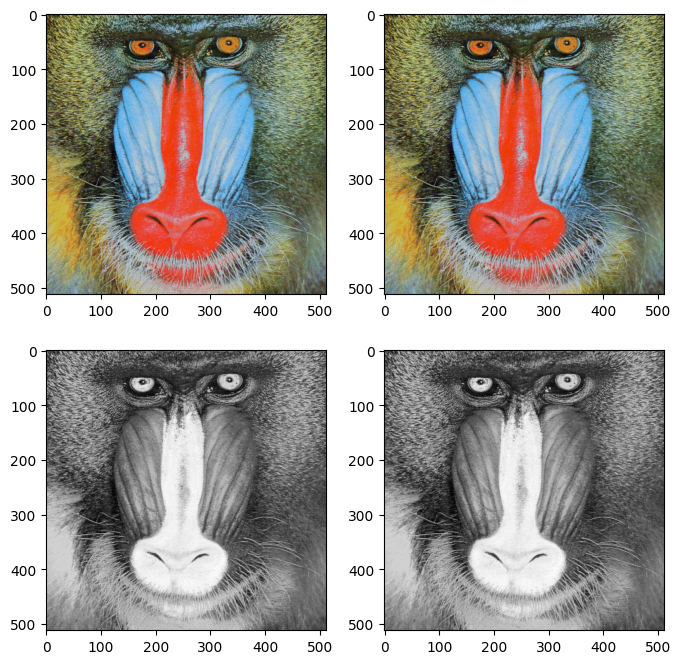

In [ ]:
imagenFilename = os.path.join("/content/Imagenes", 'mandril_color.tif')
imagenPrueba = io.imread(imagenFilename)
operadorPuntualCambioDeTono = np.vectorize(cambioDeTono)

imageHSI = RGBaHSI(imagenPrueba)
imageHSIModificada = imageHSI.copy()
imageHSIModificada[:,:,0] = operadorPuntualCambioDeTono(imageHSIModificada[:,:,0], 10)
imageRGBModificada = HSIaRGB(imageHSIModificada)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(imagenPrueba)
ax[1].imshow(imageRGBModificada)

ax[2].imshow(imageHSI[:,:,0], cmap=plt.cm.gray)
ax[3].imshow(imageHSIModificada[:,:,0], cmap=plt.cm.gray)

# Analisis por Canal
Ver cual es el canal donde los detalles son mas visibles y en en cual es mas distinguible un granulado en una imagen.

Ver a cual de los canales afectan mas los bordes difuminados.

Para este punto utilizar el data set de imagenes debajo del agua subidas al campus. Realicen ecualizacion en el canal necesario para resaltar los detalles de las imagenen, comparen con las imagenes ya post procesadas subidas al campus.

In [ ]:
imagenFilename = os.path.join("/content/Imagenes", '###############')
imagenPrueba = io.imread(imagenFilename)